In [1]:
import os
import sys
import subprocess
import torch

# Check and install PyTorch3D if not available
need_pytorch3d = False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d = True

if need_pytorch3d:
    pyt_version_str = torch.__version__.split("+")[0].replace(".", "")
    version_str = "".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    # Install dependency
    subprocess.run([sys.executable, "-m", "pip", "install", "iopath"])
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        subprocess.run([sys.executable, "-m", "pip", "install", "--no-index", "--no-cache-dir", "pytorch3d", 
                        "-f", f"https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html"])
    # Fallback: install from source if wheel installation did not work
    try:
        import pytorch3d
    except ModuleNotFoundError:
        print("Installing PyTorch3D from source")
        subprocess.run([sys.executable, "-m", "pip", "install", "ninja"])
        subprocess.run([sys.executable, "-m", "pip", "install", "git+https://github.com/facebookresearch/pytorch3d.git@stable"])

In [2]:
# Import necessary libraries and modules
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
from skimage import img_as_ubyte
from IPython.display import clear_output

# PyTorch3D imports
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.transforms import Rotate, Translate
from pytorch3d.renderer import (
    FoVPerspectiveCameras, RasterizationSettings, MeshRenderer, MeshRasterizer,
    BlendParams, SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
    look_at_view_transform, look_at_rotation
)

# For interactive 3D visualization
import plotly.graph_objects as go

# For image processing
import cv2

In [3]:
# Device selection: use GPU if available, else CPU.
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU


In [4]:
# ### Mesh Loading and Texturing
# Update `mesh_path` to point to your OBJ file.
mesh_path = "/home/exouser/pose_estim/clipestimator/data/mesh/clipMesh.obj"
verts, faces_idx, _ = load_obj(mesh_path)
faces = faces_idx.verts_idx

# Set all vertices to white.
verts_rgb = torch.ones_like(verts)[None]  # shape: (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the mesh.
clip_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures
)

/home/exouser/anaconda3/envs/blvenv/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: /home/exouser/pose_estim/clipestimator/data/mesh/Item.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [5]:
# Create two renderers:
# 1. A silhouette renderer (using a soft shader).
# 2. A Phong renderer (for visualization).

# Initialize a perspective camera.
cameras = FoVPerspectiveCameras(device=device)

# Silhouette renderer settings.
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings_silhouette = RasterizationSettings(
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
    faces_per_pixel=25,
    bin_size=0,
)
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings_silhouette),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

# Phong renderer settings for visualization.
raster_settings_phong = RasterizationSettings(
    image_size=128,
    blur_radius=0.0,
    faces_per_pixel=1,
    bin_size=0,
)
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings_phong),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

Reference Rotation:
 tensor([[[ 0.8660, -0.1294, -0.4830],
         [-0.0000,  0.9659, -0.2588],
         [ 0.5000,  0.2241,  0.8365]]], device='cuda:0')
Reference Translation:
 tensor([[-0.0000e+00, 4.7684e-07, 3.0000e+01]], device='cuda:0')


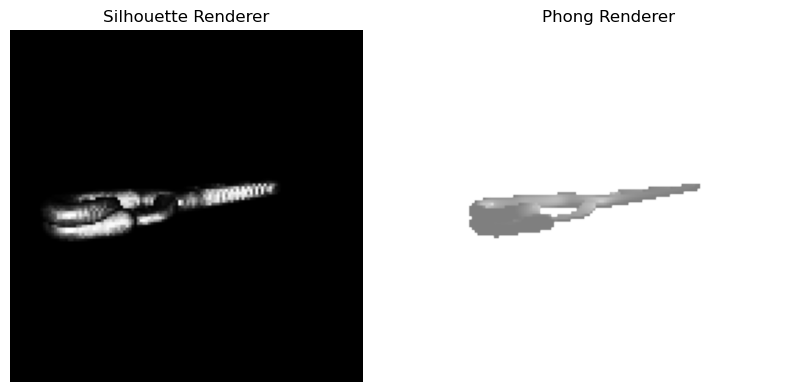

In [6]:
# ### Compute a Reference View
# Using spherical angles, compute the view transformation.
distance = 30
elevation = 15.0
azimuth = 150.0
R_t, T_t = look_at_view_transform(distance, elevation, azimuth, device=device)
print("Reference Rotation:\n", R_t)
print("Reference Translation:\n", T_t)

# Render a silhouette and a Phong image for reference.
silhouette = silhouette_renderer(meshes_world=clip_mesh, R=R_t, T=T_t)
image_ref = phong_renderer(meshes_world=clip_mesh, R=R_t, T=T_t)

# Convert images to NumPy arrays for display.
silhouette_np = silhouette.cpu().numpy()
image_ref_np = image_ref.cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(silhouette_np.squeeze()[..., 3], cmap="gray")
plt.title("Silhouette Renderer")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(image_ref_np.squeeze())
plt.title("Phong Renderer")
plt.axis("off")
plt.show()

In [7]:
# ### Define the Camera Optimization Model
# This model has a learnable camera position parameter.
# Its forward pass computes the view transformation from the camera position,
# renders a silhouette, and computes the loss compared to the binary reference image.
class CameraOptimizationModel(nn.Module):
    """
    A model that can either:
      - Derive a binary silhouette from a reference RGB image (old approach).
      - Use a user-provided binary silhouette directly (new approach).

    Usage:
        # Old approach (preserves existing functionality):
        model = CameraOptimizationModel(
            meshes=clip_mesh,
            renderer=silhouette_renderer,
            reference_image=my_reference_rgb  # shape [H, W, 3 or 4], for example
        )

        # New approach (use external silhouette):
        model = CameraOptimizationModel(
            meshes=clip_mesh,
            renderer=silhouette_renderer,
            external_silhouette=my_binary_silhouette  # shape [H, W], values in {0,1}
        )
    """
    def __init__(
        self,
        meshes,
        renderer,
        reference_image=None,
        external_silhouette=None,
    ):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer

        if external_silhouette is not None:
            # ---- New Approach: direct binary silhouette
            if not isinstance(external_silhouette, torch.Tensor):
                external_silhouette = torch.from_numpy(external_silhouette)
            external_silhouette = external_silhouette.float().to(self.device)
            self.register_buffer("image_ref", external_silhouette)

        elif reference_image is not None:
            # ---- Old Approach: derive silhouette from an RGB reference
            #   e.g. "white = background, everything else = silhouette"
            if not isinstance(reference_image, torch.Tensor):
                reference_image = torch.from_numpy(reference_image)
            reference_image = reference_image.float().to(self.device)
            # If shape is [H, W, 3 or 4], find silhouette where the max channel != 1
            # (this matches the original code's logic).
            # Squeeze batch dimension if it exists, etc., as needed.
            silhouette_bin = (reference_image[..., :3].max(dim=-1).values != 1.0).float()
            self.register_buffer("image_ref", silhouette_bin)
        else:
            raise ValueError(
                "You must provide either `reference_image` (old approach) "
                "or `external_silhouette` (new approach)."
            )

        # Create a learnable camera parameter.
        self.camera_position = nn.Parameter(
            torch.tensor([20.0, 20.0, 20.0], dtype=torch.float32, device=self.device)
        )

    def forward(self):
        """
        1. Compute the rotation/translation from the camera position.
        2. Render the silhouette (the alpha channel).
        3. Compare to the reference silhouette via MSE (or another loss).
        """
        R = look_at_rotation(self.camera_position[None, :], device=self.device)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]

        # Render the mesh. The shape is [batch=1, H, W, RGBA=4].
        rendered_image = self.renderer(meshes_world=self.meshes, R=R, T=T)
        
        # Extract alpha channel -> shape [1, H, W].
        alpha_render = rendered_image[0, ..., 3]
        
        # Compare alpha to our reference silhouette.
        loss = torch.mean((alpha_render - self.image_ref) ** 2)
        
        return loss, rendered_image

# Instantiate the model.
model = CameraOptimizationModel(meshes=clip_mesh, renderer=silhouette_renderer, reference_image=image_ref_np).to(device)

In [8]:
# ### Utility Functions for Optimization
def random_camera_position(min_distance, max_distance, device):
    distance = np.random.uniform(min_distance, max_distance)
    azimuth = np.random.uniform(0, 360)
    elevation = np.random.uniform(-90, 90)
    x = distance * np.cos(np.radians(elevation)) * np.cos(np.radians(azimuth))
    y = distance * np.cos(np.radians(elevation)) * np.sin(np.radians(azimuth))
    z = distance * np.sin(np.radians(elevation))
    return torch.tensor([x, y, z], device=device, dtype=torch.float32)

def random_nearby_position(reference_position, deviation, device):
    noise = np.random.uniform(-deviation, deviation, size=(3,))
    new_position = reference_position.cpu().numpy() + noise
    return torch.tensor(new_position, device=device, dtype=torch.float32)

def generate_target_positions(min_distance, max_distance, num_points):
    azimuths = np.random.uniform(0, 360, num_points)
    elevations = np.random.uniform(-90, 90, num_points)
    distances = np.random.uniform(min_distance, max_distance, num_points)
    targets = []
    for az, el, d in zip(azimuths, elevations, distances):
        x = d * np.cos(np.radians(el)) * np.cos(np.radians(az))
        y = d * np.cos(np.radians(el)) * np.sin(np.radians(az))
        z = d * np.sin(np.radians(el))
        targets.append([x, y, z])
    return torch.tensor(targets, dtype=torch.float32)

def optimize_camera_position(target_position, device, model,
                               num_initial_restarts=15, num_refined_restarts=5,
                               num_iterations_min=200, num_iterations_max=400,
                               patience=20, significant_improvement=0.001,
                               nearby_deviation=5.0, plot_losses=False):
    best_loss = float('inf')
    best_camera_position = None
    all_restart_results = []

    # Initial random restarts.
    for restart in range(num_initial_restarts):
        model.camera_position.data = random_camera_position(40, 50, device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        loss_values = []
        prev_loss = float('inf')
        no_improve_counter = 0

        for i in range(num_iterations_max):
            optimizer.zero_grad()
            loss, _ = model()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            loss_values.append(loss.item())
            
            if loss.item() >= prev_loss - significant_improvement:
                no_improve_counter += 1
            else:
                no_improve_counter = 0
            prev_loss = loss.item()
            
            if no_improve_counter >= patience and i >= num_iterations_min:
                break

        # Plot the loss curve for this initial restart if requested.
        if plot_losses:
            plt.figure(figsize=(6,4))
            plt.plot(loss_values, label=f"Initial Restart {restart+1}")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.title(f"Loss Curve (Initial Restart {restart+1})")
            plt.ylim(0, 0.05)
            plt.legend()
            plt.grid(True)
            plt.show()

        restart_result = {
            'final_loss': loss_values[-1],
            'camera_position': model.camera_position.data.clone(),
            'loss_values': loss_values
        }
        all_restart_results.append(restart_result)
        
        if loss_values[-1] < best_loss:
            best_loss = loss_values[-1]
            best_camera_position = model.camera_position.data.clone()
    
    best_initial_restart = min(all_restart_results, key=lambda x: x['final_loss'])

    # Refined restarts near the best initial restart.
    for restart in range(num_refined_restarts):
        model.camera_position.data = random_nearby_position(best_initial_restart['camera_position'], nearby_deviation, device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
        loss_values = []
        prev_loss = float('inf')
        no_improve_counter = 0

        for i in range(num_iterations_max):
            optimizer.zero_grad()
            loss, _ = model()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            loss_values.append(loss.item())
            
            if loss.item() >= prev_loss - significant_improvement:
                no_improve_counter += 1
            else:
                no_improve_counter = 0
            prev_loss = loss.item()
            
            if no_improve_counter >= patience and i >= num_iterations_min:
                break

        # Plot the loss curve for this refined restart if requested.
        if plot_losses:
            plt.figure(figsize=(6,4))
            plt.plot(loss_values, label=f"Refined Restart {restart+1}")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.title(f"Loss Curve (Refined Restart {restart+1})")
            plt.ylim(0, 0.05)
            plt.legend()
            plt.grid(True)
            plt.show()
            
        if loss_values[-1] < best_loss:
            best_loss = loss_values[-1]
            best_camera_position = model.camera_position.data.clone()

    error = torch.norm(best_camera_position - target_position.to(device)).item()
    return {
        "target_pos": target_position.cpu().numpy(),
        "estimated_pos": best_camera_position.cpu().numpy(),
        "final_loss": best_loss,
        "error": error
    }


def compute_atomic_error(best_camera_position, target_position, model, clip_mesh, scale_factor=1.0):
    # Transform mesh vertices.
    verts_target = clip_mesh.verts_packed() * scale_factor
    R_f = look_at_rotation(best_camera_position[None, :], device=model.device)
    T_f = -torch.bmm(R_f.transpose(1, 2), best_camera_position[None, :, None])[:, :, 0]
    verts_final = torch.matmul(verts_target, R_f.transpose(1, 2)[0]) + T_f[0]
    
    # Ground truth transformation using the target position.
    R_t = look_at_rotation(target_position[None, :], device=model.device)
    T_t = -torch.bmm(R_t.transpose(1, 2), target_position[None, :, None])[:, :, 0]
    verts_target_transformed = torch.matmul(verts_target, R_t.transpose(1, 2)[0]) + T_t[0]
    
    deviations = torch.norm(verts_target_transformed - verts_final, dim=1)
    return deviations.max().item()

In [ ]:
# ### Multi-Target Optimization and Visualization
num_targets = 50  # Adjust as needed
target_positions = generate_target_positions(30, 50, num_targets)
results = []
print("Running optimization on multiple target positions...")
for target_pos in tqdm(target_positions):
    result = optimize_camera_position(target_pos, device, model)
    atomic_error = compute_atomic_error(torch.tensor(result["estimated_pos"], device=device),
                                          torch.tensor(result["target_pos"], device=device),
                                          model, clip_mesh)
    result["atomic_error"] = atomic_error
    results.append(result)

# Prepare data for Plotly.
positions = np.array([r["target_pos"] for r in results])
atomic_errors = np.array([r["atomic_error"] for r in results])
verts_clip = clip_mesh.verts_packed().cpu().numpy()
hard_min = 0
soft_max = np.max(atomic_errors) * 1.1

scatter = go.Scatter3d(
    x=positions[:,0], y=positions[:,1], z=positions[:,2],
    mode='markers',
    marker=dict(
        size=6,
        color=atomic_errors,
        colorscale='Viridis',
        cmin=hard_min,
        cmax=soft_max,
        showscale=True,
        colorbar=dict(title="Atomic Error")
    ),
    name="Target Positions"
)
clip_mesh_scatter = go.Scatter3d(
    x=verts_clip[:,0], y=verts_clip[:,1], z=verts_clip[:,2],
    mode='markers',
    marker=dict(size=1, color='gray', opacity=0.3),
    name="Clip Mesh"
)
fig = go.Figure(data=[clip_mesh_scatter, scatter])
fig.update_layout(
    title="Target Position Difficulty Map (Atomic Error)",
    scene=dict(
        xaxis_title="X", yaxis_title="Y", zaxis_title="Z",
        aspectmode="cube"
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.show()

/tmp/ipykernel_4008/2114001438.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  silhouette_img = imageio.imread(clip_silhouette_path)


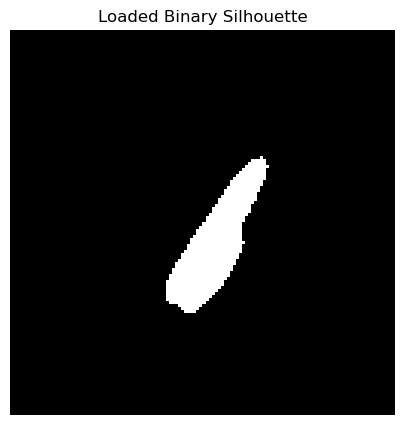

In [9]:
# Path to silhouette image
clip_silhouette_path = "/home/exouser/pose_estim/clipestimator/data/baseline/segment/bin_baseline1.png"

# Read the silhouette image (white=clip, black=background).
# Depending on image, this may return a shape [H, W] or [H, W, 3/4].
silhouette_img = imageio.imread(clip_silhouette_path)

# Convert to float in [0,1].
silhouette_img = silhouette_img.astype(np.float32) / 255.0

# If it's a 3-channel or 4-channel image, reduce it to one channel.
if silhouette_img.ndim == 3:
    # e.g., take the first channel, or the mean, etc. if truly black/white
    silhouette_img = silhouette_img[..., 0]

# Optionally, resize the image to match your renderer resolution (e.g., 128x128).
target_size = 128  # Must match your RasterizationSettings(image_size=128)
silhouette_img = cv2.resize(
    silhouette_img, (target_size, target_size),
    interpolation=cv2.INTER_NEAREST  # helps preserve crisp edges
)

# Convert to a strict binary mask (0 or 1).
# If your silhouette is purely black/white, threshold at 0.5.
silhouette_binary = (silhouette_img > 0.5).astype(np.float32)

# Now silhouette_binary is a 2D NumPy array in [0,1].

plt.figure(figsize=(5, 5))
plt.imshow(silhouette_binary, cmap="gray")
plt.title("Loaded Binary Silhouette")
plt.axis("off")
plt.show()

In [10]:
model = CameraOptimizationModel(
    meshes=clip_mesh,
    renderer=silhouette_renderer,
    external_silhouette=silhouette_binary  # external silhouette
).to(device)

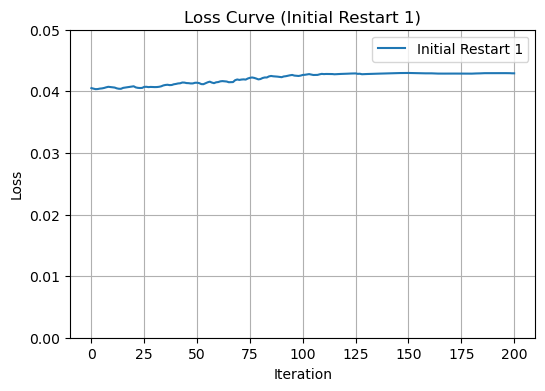

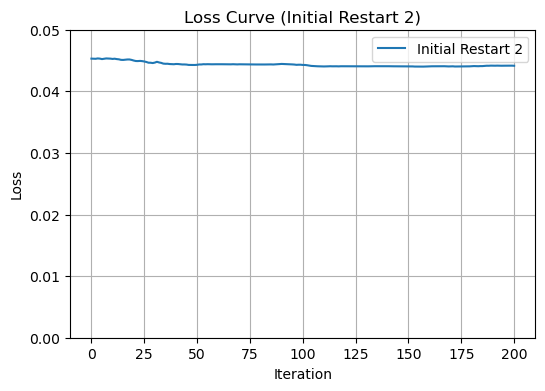

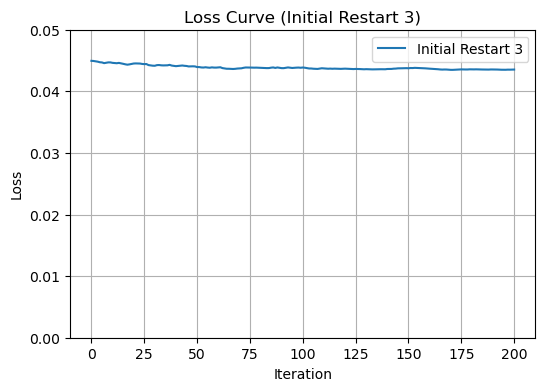

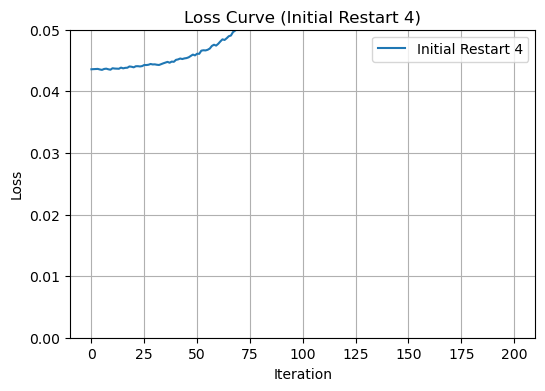

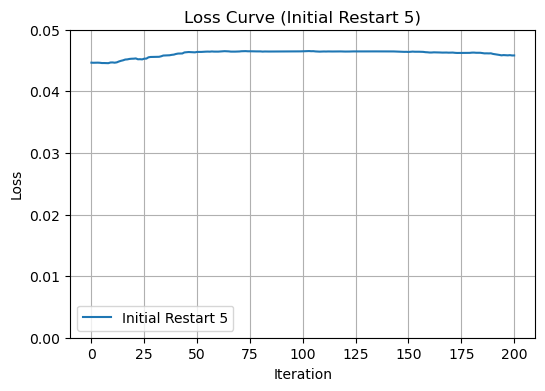

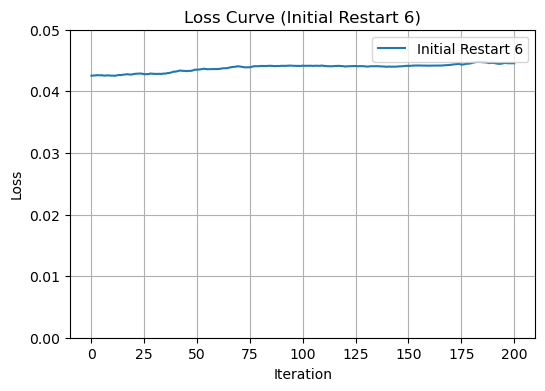

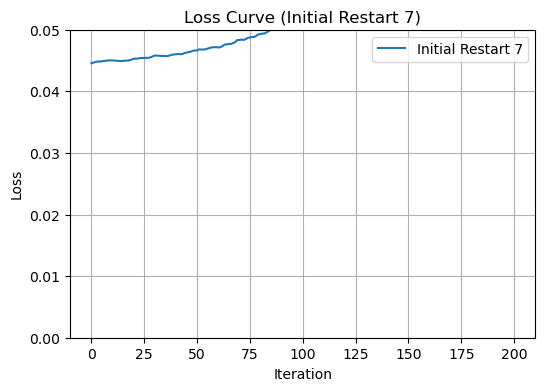

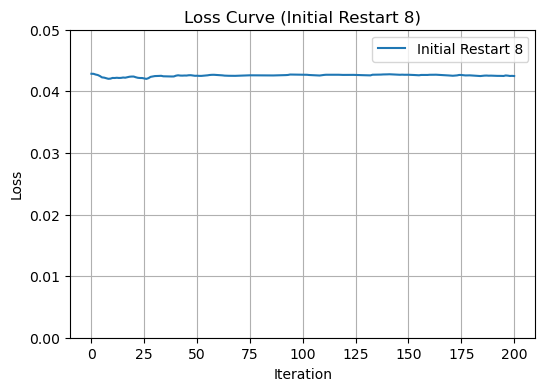

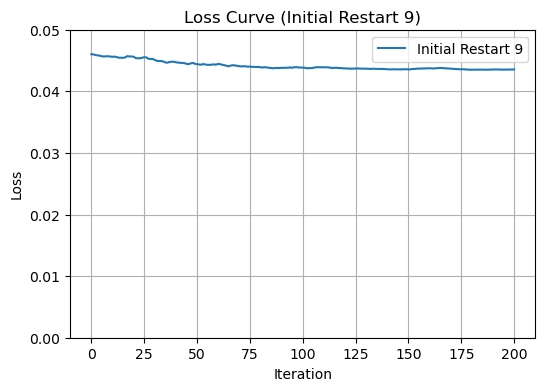

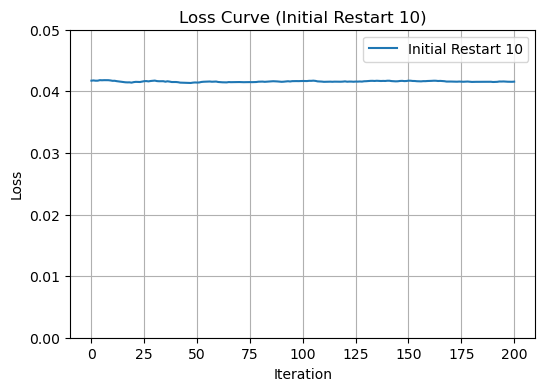

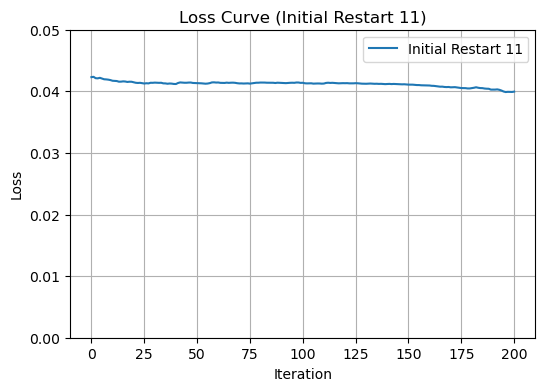

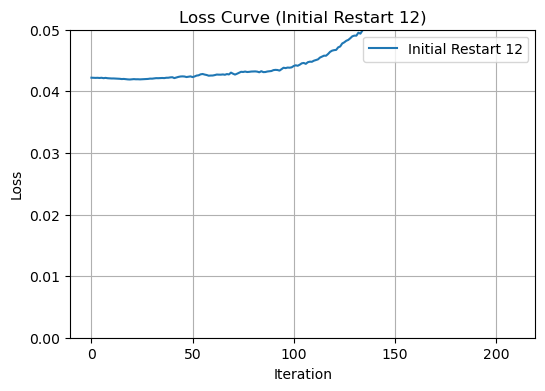

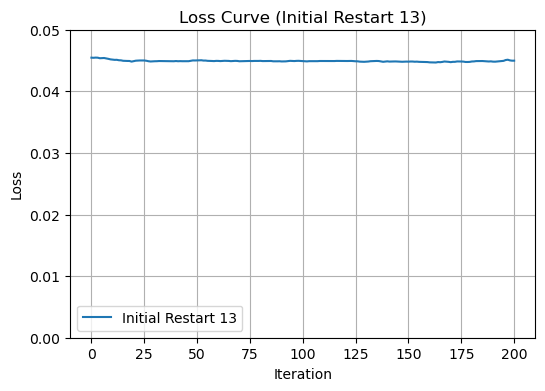

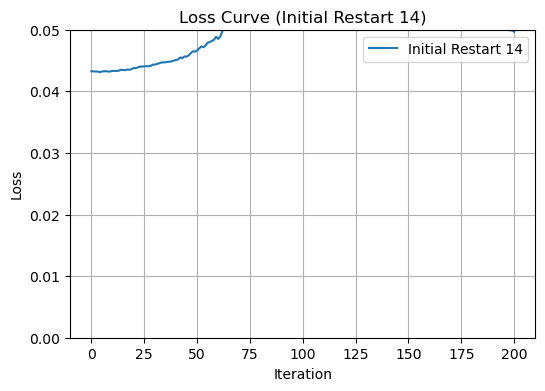

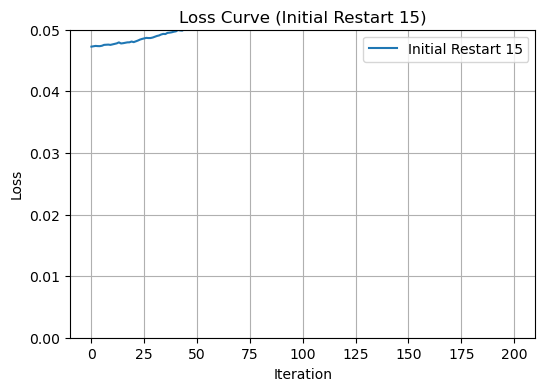

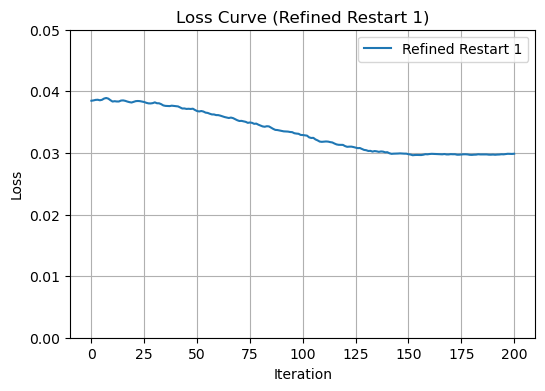

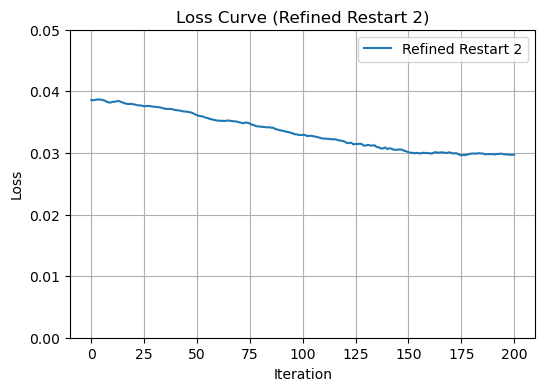

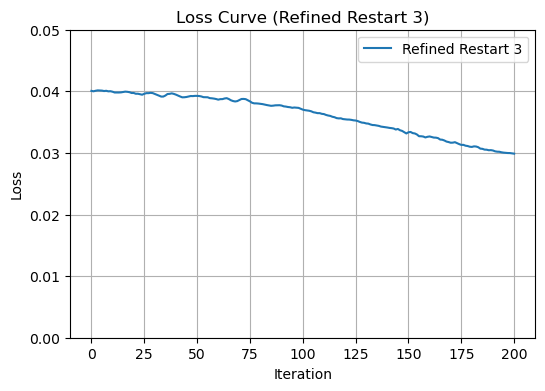

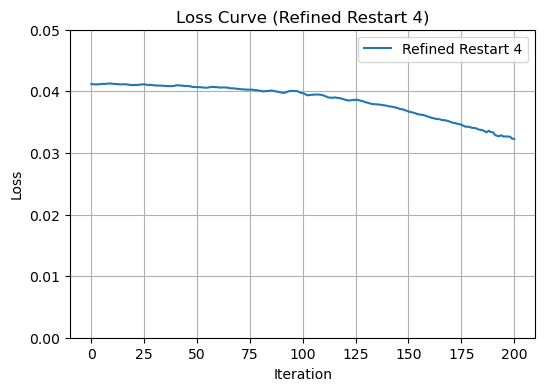

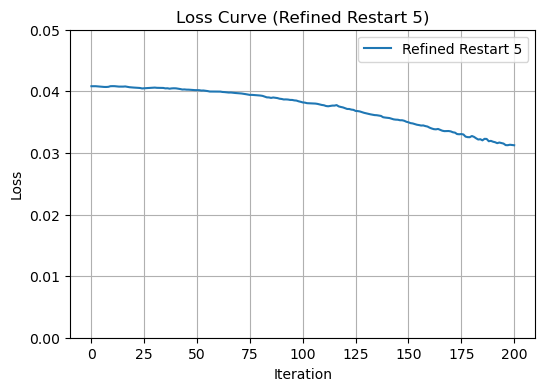

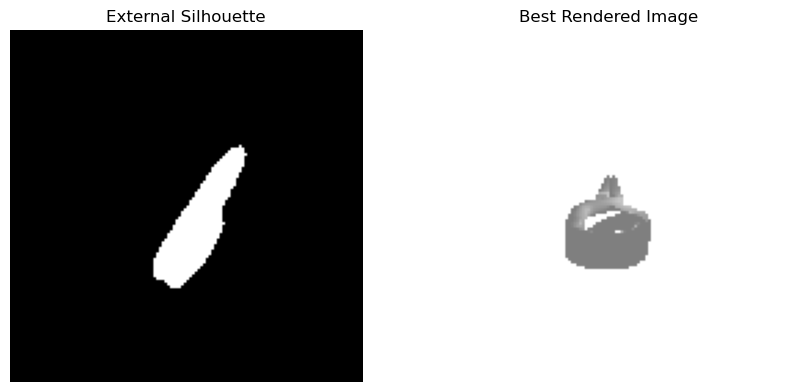

Best Loss: 0.029712896794080734


In [12]:
# ### Single Target Refined Optimization for Final Visualization
# Set the target mode: "external" to use an external silhouette (silhouette_binary),
# or "random" to optimize toward a randomly generated camera position.
target_mode = "external"  # or "random"

if target_mode == "random":
    # In "random" mode, we generate a target camera position and optimize to match it.
    target_position = random_camera_position(40, 50, device)
    print("Target Camera Position (randomly generated):", target_position.cpu().numpy())
    
    # Optimize camera position using the multi-restart regime.
    result = optimize_camera_position(target_position, device, model, plot_losses=True)
    best_camera_position = torch.tensor(result["estimated_pos"], device=device)
    
    # Compute the final rotation and translation from the best camera position.
    R_final = look_at_rotation(best_camera_position[None, :], device=device)
    T_final = -torch.bmm(R_final.transpose(1, 2), best_camera_position[None, :, None])[:, :, 0]
    
    # Render the final image using the Phong renderer.
    final_rendered_image = phong_renderer(
        meshes_world=model.meshes.clone(), R=R_final, T=T_final
    )[0, ..., :3].detach().cpu().numpy()
    
    # Display the (derived) target silhouette and the best rendered image.
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    # Here, model.image_ref was set from the reference image (old approach).
    plt.imshow(model.image_ref.cpu().squeeze(), cmap="gray")
    plt.title("Target Silhouette (Derived)")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(final_rendered_image)
    plt.title("Best Rendered Image")
    plt.axis("off")
    plt.show()
    
    print("Best Loss:", result["final_loss"])
    print("Best Camera Position:", result["estimated_pos"])

else:  # target_mode == "external"
    # In "external" mode, the model is built with an external binary silhouette
    # (i.e. silhouette_binary) as its reference target.
    #
    # Since there isn't a corresponding target camera position to compute an error,
    # we use a dummy target position for the multi-restart process. (The optimization
    # still minimizes the MSE between the rendered alpha and the external silhouette.)
    dummy_target = random_camera_position(40, 50, device)
    result = optimize_camera_position(dummy_target, device, model, plot_losses=True)
    best_camera_position = torch.tensor(result["estimated_pos"], device=device)
    
    # Compute the final rotation and translation.
    R_final = look_at_rotation(best_camera_position[None, :], device=device)
    T_final = -torch.bmm(R_final.transpose(1, 2), best_camera_position[None, :, None])[:, :, 0]
    
    # Render the final image.
    final_rendered_image = phong_renderer(
        meshes_world=model.meshes.clone(), R=R_final, T=T_final
    )[0, ..., :3].detach().cpu().numpy()
    
    # Display the external silhouette (loaded from the PNG) and the best rendered image.
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    # The model's reference silhouette here is the externally loaded binary mask.
    plt.imshow(model.image_ref.cpu().squeeze(), cmap="gray")
    plt.title("External Silhouette")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(final_rendered_image)
    plt.title("Best Rendered Image")
    plt.axis("off")
    plt.show()
    
    print("Best Loss:", result["final_loss"])

Bounding Box Dimensions: [24.488085   2.680991   6.3696203]
Maximum Deviation: 3.5368759632110596


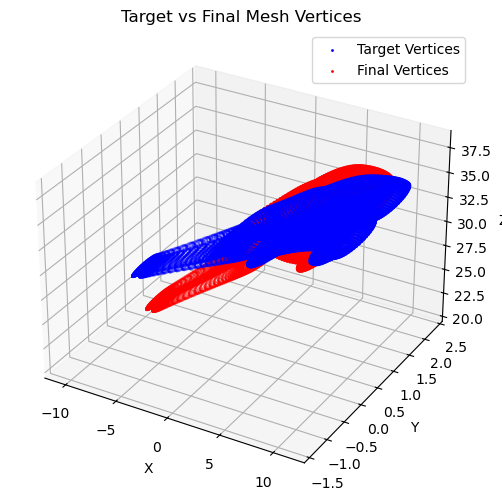

In [15]:
# ### Error Analysis and 3D Mesh Vertex Comparison
scale_factor = 1.0
verts_target = clip_mesh.verts_packed() * scale_factor
R_final = look_at_rotation(best_camera_position[None, :], device=device)
T_final = -torch.bmm(R_final.transpose(1,2), best_camera_position[None, :, None])[:, :, 0]
verts_final = torch.matmul(verts_target, R_final.transpose(1,2)[0]) + T_final[0]

# Use the reference transformation from earlier.
verts_target_transformed = torch.matmul(verts_target, R_t.transpose(1,2)[0]) + T_t[0]
deviations = torch.norm(verts_target_transformed - verts_final, dim=1)
max_deviation = deviations.max().item()

print("Bounding Box Dimensions:", (verts_target.max(dim=0).values - verts_target.min(dim=0).values).cpu().numpy())
print("Maximum Deviation:", max_deviation)

# 3D scatter plot using matplotlib.
from mpl_toolkits.mplot3d import Axes3D
verts_target_np = verts_target_transformed.cpu().numpy()
verts_final_np = verts_final.cpu().numpy()

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(verts_target_np[:,0], verts_target_np[:,1], verts_target_np[:,2],
           c='blue', label='Target Vertices', s=1)
ax.scatter(verts_final_np[:,0], verts_final_np[:,1], verts_final_np[:,2],
           c='red', label='Final Vertices', s=1)
ax.set_title("Target vs Final Mesh Vertices")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()